In [28]:
import json
import re
from collections import defaultdict, Counter

# Laad de resultaten
print("Loading data...")
with open('../data/rhyme_analysis_by_word.json', 'r', encoding='utf-8') as f:
    results_by_word = json.load(f)

with open('../data/stresses_restructured.json', 'r', encoding='utf-8') as f:
    stress_data = json.load(f)

print("\n" + "="*80)
print("ANALYSE: -e vs -en RIJMEN IN ONBEKLEMTOONDE LETTERGREEP (SLOT-N PROBLEMATIEK)")
print("Niveau: STROFES")
print("="*80)

# ============================================================================
# FUNCTIE: CHECK OF -e/-en IN ONBEKLEMTOONDE LETTERGREEP STAAT
# ============================================================================

def has_unstressed_e_or_en(word, debug=False):
    """
    Check of het woord eindigt op -e of -en in een onbeklemtoonde lettergreep.
    Returns: 'unstressed_e', 'unstressed_en', of None
    """
    word = word.lower().strip()
    
    # Haal data op uit stress_data
    if word not in stress_data:
        if debug:
            print(f"  {word}: NIET in stress_data")
        return None
    
    entry = stress_data[word]
    
    # Als er meerdere vormen zijn, neem de eerste
    if isinstance(entry, list):
        entry = entry[0]
    
    syllabified = entry['syllabified']
    stresses = entry['stresses']
    
    if debug:
        print(f"  {word}: {syllabified}, stresses: {stresses}")
    
    # Check of er minstens 2 lettergrepen zijn
    if not syllabified or len(syllabified) < 2:
        if debug:
            print(f"    → Te weinig lettergrepen")
        return None
    
    num_syllables = len(syllabified)
    last_syllable_index = num_syllables - 1
    
    # Converteer negatieve indices naar positieve
    positive_stresses = []
    for s in stresses:
        if s < 0:
            # -1 wordt laatste index, -2 wordt voorlaatste, etc.
            positive_stresses.append(num_syllables + s)
        else:
            positive_stresses.append(s)
    
    # Is de laatste lettergreep beklemtoond?
    is_stressed = last_syllable_index in positive_stresses
    
    if debug:
        print(f"    → Aantal lettergrepen: {num_syllables}")
        print(f"    → Laatste lettergreep index: {last_syllable_index}")
        print(f"    → Positive stresses: {positive_stresses}")
        print(f"    → Is laatste beklemtoond: {is_stressed}")
    
    # Als beklemtoond, dan niet relevant
    if is_stressed:
        if debug:
            print(f"    → BEKLEMTOOND, niet relevant")
        return None
    
    # Check of het woord eindigt op -e of -en
    if word.endswith('en'):
        if debug:
            print(f"    → ONBEKLEMTOOND -en ✓")
        return 'unstressed_en'
    elif word.endswith('e'):
        if debug:
            print(f"    → ONBEKLEMTOOND -e ✓")
        return 'unstressed_e'
    
    return None

# ============================================================================
# VERZAMEL DATA PER STROFE
# ============================================================================

strofe_data = defaultdict(lambda: {
    'manuscript': None,
    'section': None,
    'strofe': None,
    'has_unstressed_e': False,
    'has_unstressed_en': False,
    'has_unstressed_e_en_rhyme': False,
    'unstressed_e_words': [],
    'unstressed_en_words': [],
    'e_en_pairs': []
})

for manuscript, words in results_by_word.items():
    for word_entry in words:
        if word_entry['status'] != 'analyzed':
            continue
        
        strofe_key = (manuscript, word_entry['section'], word_entry['strofe'])
        
        # Initialiseer strofe info
        if strofe_data[strofe_key]['manuscript'] is None:
            strofe_data[strofe_key]['manuscript'] = manuscript
            strofe_data[strofe_key]['section'] = word_entry['section']
            strofe_data[strofe_key]['strofe'] = word_entry['strofe']
        
        word = word_entry['word']
        
        # Check of het onbeklemtoonde -e of -en is
        unstressed_type = has_unstressed_e_or_en(word)
        
        if unstressed_type == 'unstressed_e':
            strofe_data[strofe_key]['has_unstressed_e'] = True
            strofe_data[strofe_key]['unstressed_e_words'].append(word)
        elif unstressed_type == 'unstressed_en':
            strofe_data[strofe_key]['has_unstressed_en'] = True
            strofe_data[strofe_key]['unstressed_en_words'].append(word)
        
        # Check of er onbeklemtoonde -e:-en rijm is
        if unstressed_type and 'rhyme_details' in word_entry and 'full' in word_entry['rhyme_details']:
            for partner_word in word_entry['rhyme_details']['full']:
                partner_unstressed_type = has_unstressed_e_or_en(partner_word)
                
                # Check of het een onbeklemtoonde -e:-en combinatie is
                if (unstressed_type == 'unstressed_e' and partner_unstressed_type == 'unstressed_en') or \
                   (unstressed_type == 'unstressed_en' and partner_unstressed_type == 'unstressed_e'):
                    strofe_data[strofe_key]['has_unstressed_e_en_rhyme'] = True
                    
                    # Voorkom dubbele paren
                    pair = tuple(sorted([word, partner_word]))
                    existing_pairs = [tuple(sorted([p['word1'], p['word2']])) 
                                    for p in strofe_data[strofe_key]['e_en_pairs']]
                    if pair not in existing_pairs:
                        strofe_data[strofe_key]['e_en_pairs'].append({
                            'word1': word,
                            'word2': partner_word
                        })

# Alle strofes
all_strofes = list(strofe_data.values())

# Strofes met onbeklemtoonde -e en/of -en woorden (= relevant voor analyse)
relevant_strofes = [s for s in all_strofes 
                   if s['has_unstressed_e'] or s['has_unstressed_en']]

# Sub-categorieën
strofes_only_e = [s for s in relevant_strofes 
                 if s['has_unstressed_e'] and not s['has_unstressed_en']]
strofes_only_en = [s for s in relevant_strofes 
                  if s['has_unstressed_en'] and not s['has_unstressed_e']]
strofes_both = [s for s in relevant_strofes 
               if s['has_unstressed_e'] and s['has_unstressed_en']]

# Strofes met onbeklemtoonde -e:-en rijm
strofes_with_e_en_rhyme = [s for s in relevant_strofes 
                          if s['has_unstressed_e_en_rhyme']]

# ============================================================================
# STATISTIEKEN
# ============================================================================

print(f"\n--- ALGEMENE STATISTIEKEN ---")
print(f"(alleen onbeklemtoonde -e/-en eindingen)")
print(f"\nTotaal strofes: {len(all_strofes)}")
print(f"Strofes met onbeklemtoonde -e en/of -en: {len(relevant_strofes)} (noemer)")
print(f"  Waarvan alleen -e: {len(strofes_only_e)}")
print(f"  Waarvan alleen -en: {len(strofes_only_en)}")
print(f"  Waarvan beide (-e en -en): {len(strofes_both)}")

print(f"\nStrofes met onbeklemtoonde -e:-en rijm: {len(strofes_with_e_en_rhyme)} (teller)")
if relevant_strofes:
    print(f"Percentage: {len(strofes_with_e_en_rhyme)/len(relevant_strofes)*100:.2f}%")

print(f"\nVan de strofes met -e:-en rijm:")
print(f"  In strofes met beide: {sum(1 for s in strofes_with_e_en_rhyme if s in strofes_both)}")
print(f"  In strofes met alleen -e: {sum(1 for s in strofes_with_e_en_rhyme if s in strofes_only_e)} (onverwacht!)")
print(f"  In strofes met alleen -en: {sum(1 for s in strofes_with_e_en_rhyme if s in strofes_only_en)} (onverwacht!)")

# ============================================================================
# PER MANUSCRIPT
# ============================================================================

print(f"\n--- PER MANUSCRIPT ---")

manuscripts = sorted(set(s['manuscript'] for s in all_strofes if s['manuscript']))

ms_stats = {}

for ms in manuscripts:
    ms_all = [s for s in relevant_strofes if s['manuscript'] == ms]
    ms_with_rhyme = [s for s in strofes_with_e_en_rhyme if s['manuscript'] == ms]
    
    if ms_all:
        pct = len(ms_with_rhyme)/len(ms_all)*100
        
        ms_stats[ms] = {
            'total': len(ms_all),
            'with_rhyme': len(ms_with_rhyme),
            'percentage': pct
        }
        
        print(f"\n{ms}:")
        print(f"  Strofes met onbeklemtoonde -e/-en: {len(ms_all)}")
        print(f"  Met -e:-en rijm: {len(ms_with_rhyme)} ({pct:.2f}%)")
        
        ms_only_e = [s for s in ms_all if s in strofes_only_e]
        ms_only_en = [s for s in ms_all if s in strofes_only_en]
        ms_both = [s for s in ms_all if s in strofes_both]
        
        print(f"  Waarvan:")
        print(f"    Alleen -e: {len(ms_only_e)}")
        print(f"    Alleen -en: {len(ms_only_en)}")
        print(f"    Beide: {len(ms_both)}")

print(f"\n--- VERGELIJKINGSTABEL MANUSCRIPTEN ---")
print(f"\n{'Manuscript':<12} {'Strofes -e/-en':<18} {'-e:-en rijm':<15} {'Percentage':<12}")
print(f"{'-'*12} {'-'*18} {'-'*15} {'-'*12}")

for ms in manuscripts:
    if ms in ms_stats:
        stats = ms_stats[ms]
        print(f"{ms:<12} {stats['total']:<18} {stats['with_rhyme']:<15} {stats['percentage']:<12.2f}%")

print(f"\n--- VOORBEELDEN: STROFES MET ONBEKLEMTOONDE -e:-en RIJM (eerste 20) ---")

for i, strofe in enumerate(strofes_with_e_en_rhyme[:20], 1):
    print(f"\n{i}. {strofe['manuscript']} - {strofe['section']} strofe {strofe['strofe']}")
    print(f"   -e woorden (onbeklemtoond): {', '.join(strofe['unstressed_e_words'])}")
    print(f"   -en woorden (onbeklemtoond): {', '.join(strofe['unstressed_en_words'])}")
    pairs_str = ', '.join([f"{p['word1']}↔{p['word2']}" for p in strofe['e_en_pairs']])
    print(f"   Rijmparen: {pairs_str}")

# ============================================================================
# SAVE RESULTATEN
# ============================================================================

output = {
    'summary': {
        'total_strofes': len(all_strofes),
        'strofes_with_unstressed_e_or_en': len(relevant_strofes),
        'strofes_with_e_en_rhyme': len(strofes_with_e_en_rhyme),
        'percentage': len(strofes_with_e_en_rhyme)/len(relevant_strofes)*100 if relevant_strofes else 0,
        'strofes_only_e': len(strofes_only_e),
        'strofes_only_en': len(strofes_only_en),
        'strofes_both': len(strofes_both)
    },
    'per_manuscript': {},
    'per_section': {},
    'strofes_with_e_en_rhyme': []
}

for ms in manuscripts:
    ms_all = [s for s in relevant_strofes if s['manuscript'] == ms]
    ms_with_rhyme = [s for s in strofes_with_e_en_rhyme if s['manuscript'] == ms]
    
    output['per_manuscript'][ms] = {
        'total_strofes': len(ms_all),
        'strofes_with_rhyme': len(ms_with_rhyme),
        'percentage': (len(ms_with_rhyme)/len(ms_all)*100) if ms_all else 0
    }

for section in sections:
    section_all = [s for s in relevant_strofes if s['section'] == section]
    section_with_rhyme = [s for s in strofes_with_e_en_rhyme if s['section'] == section]
    
    output['per_section'][section] = {
        'total_strofes': len(section_all),
        'strofes_with_rhyme': len(section_with_rhyme),
        'percentage': (len(section_with_rhyme)/len(section_all)*100) if section_all else 0
    }

# Voeg strofe details toe
for strofe in strofes_with_e_en_rhyme:
    output['strofes_with_e_en_rhyme'].append({
        'manuscript': strofe['manuscript'],
        'section': strofe['section'],
        'strofe': strofe['strofe'],
        'unstressed_e_words': strofe['unstressed_e_words'],
        'unstressed_en_words': strofe['unstressed_en_words'],
        'pairs': strofe['e_en_pairs']
    })

#with open('../data/e_en_unstressed_analysis.json', 'w', encoding='utf-8') as f:
 #   json.dump(output, f, indent=2, ensure_ascii=False)

# CSV voor Excel
#with open('../data/e_en_unstressed_per_manuscript.csv', 'w', encoding='utf-8') as f:
#    f.write("Manuscript,Strofes_met_onbeklemtoonde_e_of_en,Strofes_met_e_en_rijm,Percentage\n")
#    for ms in manuscripts:
 #       if ms in ms_stats:
  #          stats = ms_stats[ms]
   #         f.write(f"{ms},{stats['total']},{stats['with_rhyme']},{stats['percentage']:.2f}\n")

print(f"\n Resultaten opgeslagen:")
print(f"   - e_en_unstressed_analysis.json (volledige analyse)")
print(f"   - e_en_unstressed_per_manuscript.csv (voor Excel)")

Loading data...

ANALYSE: -e vs -en RIJMEN IN ONBEKLEMTOONDE LETTERGREEP (SLOT-N PROBLEMATIEK)
Niveau: STROFES

--- ALGEMENE STATISTIEKEN ---
(alleen onbeklemtoonde -e/-en eindingen)

Totaal strofes: 1255
Strofes met onbeklemtoonde -e en/of -en: 1218 (noemer)
  Waarvan alleen -e: 614
  Waarvan alleen -en: 519
  Waarvan beide (-e en -en): 85

Strofes met onbeklemtoonde -e:-en rijm: 81 (teller)
Percentage: 6.65%

Van de strofes met -e:-en rijm:
  In strofes met beide: 81
  In strofes met alleen -e: 0 (onverwacht!)
  In strofes met alleen -en: 0 (onverwacht!)

--- PER MANUSCRIPT ---

A:
  Strofes met onbeklemtoonde -e/-en: 134
  Met -e:-en rijm: 8 (5.97%)
  Waarvan:
    Alleen -e: 68
    Alleen -en: 58
    Beide: 8

B:
  Strofes met onbeklemtoonde -e/-en: 138
  Met -e:-en rijm: 7 (5.07%)
  Waarvan:
    Alleen -e: 74
    Alleen -en: 56
    Beide: 8

Br:
  Strofes met onbeklemtoonde -e/-en: 46
  Met -e:-en rijm: 4 (8.70%)
  Waarvan:
    Alleen -e: 20
    Alleen -en: 22
    Beide: 4

C:
  St

In [21]:
print("Loading data...")
with open('../data/rhyme_analysis_by_word.json', 'r', encoding='utf-8') as f:
    results_by_word = json.load(f)

with open('../data/stresses_restructured.json', 'r', encoding='utf-8') as f:
    stress_data = json.load(f)

print("\n" + "="*80)
print("ANALYSE: -e vs -en RIJMEN (MET COMPLETENESS FILTER)")
print("Filter: Exclude incomplete strofes BEHALVE die met beide -e en -en")
print("="*80)

# ============================================================================
# FUNCTIE: CHECK OF -e/-en IN ONBEKLEMTOONDE LETTERGREEP STAAT
# ============================================================================

def has_unstressed_e_or_en(word, debug=False):
    """
    Check of het woord eindigt op -e of -en in een onbeklemtoonde lettergreep.
    Returns: 'unstressed_e', 'unstressed_en', of None
    """
    word = word.lower().strip()
    
    if word not in stress_data:
        if debug:
            print(f"  {word}: NIET in stress_data")
        return None
    
    entry = stress_data[word]
    
    if isinstance(entry, list):
        entry = entry[0]
    
    syllabified = entry['syllabified']
    stresses = entry['stresses']
    
    if debug:
        print(f"  {word}: {syllabified}, stresses: {stresses}")
    
    if not syllabified or len(syllabified) < 2:
        if debug:
            print(f"    → Te weinig lettergrepen")
        return None
    
    num_syllables = len(syllabified)
    last_syllable_index = num_syllables - 1
    
    # Converteer negatieve indices naar positieve
    positive_stresses = []
    for s in stresses:
        if s < 0:
            positive_stresses.append(num_syllables + s)
        else:
            positive_stresses.append(s)
    
    is_stressed = last_syllable_index in positive_stresses
    
    if debug:
        print(f"    → Laatste lettergreep index: {last_syllable_index}")
        print(f"    → Positive stresses: {positive_stresses}")
        print(f"    → Is laatste beklemtoond: {is_stressed}")
    
    if is_stressed:
        if debug:
            print(f"    → BEKLEMTOOND, niet relevant")
        return None
    
    if word.endswith('en'):
        if debug:
            print(f"    → ONBEKLEMTOOND -en ✓")
        return 'unstressed_en'
    elif word.endswith('e'):
        if debug:
            print(f"    → ONBEKLEMTOOND -e ✓")
        return 'unstressed_e'
    
    return None

strofe_data = defaultdict(lambda: {
    'manuscript': None,
    'section': None,
    'strofe': None,
    'total_words': 0,
    'has_unstressed_e': False,
    'has_unstressed_en': False,
    'has_unstressed_e_en_rhyme': False,
    'unstressed_e_words': [],
    'unstressed_en_words': [],
    'e_en_pairs': []
})

for manuscript, words in results_by_word.items():
    for word_entry in words:
        strofe_key = (manuscript, word_entry['section'], word_entry['strofe'])
        
        if strofe_data[strofe_key]['manuscript'] is None:
            strofe_data[strofe_key]['manuscript'] = manuscript
            strofe_data[strofe_key]['section'] = word_entry['section']
            strofe_data[strofe_key]['strofe'] = word_entry['strofe']

        strofe_data[strofe_key]['total_words'] += 1
        
        if word_entry['status'] != 'analyzed':
            continue
        
        word = word_entry['word']
        
        # Check of het onbeklemtoonde -e of -en is
        unstressed_type = has_unstressed_e_or_en(word)
        
        if unstressed_type == 'unstressed_e':
            strofe_data[strofe_key]['has_unstressed_e'] = True
            strofe_data[strofe_key]['unstressed_e_words'].append(word)
        elif unstressed_type == 'unstressed_en':
            strofe_data[strofe_key]['has_unstressed_en'] = True
            strofe_data[strofe_key]['unstressed_en_words'].append(word)
        
        # Check of er onbeklemtoonde -e:-en rijm is
        if unstressed_type and 'rhyme_details' in word_entry and 'full' in word_entry['rhyme_details']:
            for partner_word in word_entry['rhyme_details']['full']:
                partner_unstressed_type = has_unstressed_e_or_en(partner_word)
                
                if (unstressed_type == 'unstressed_e' and partner_unstressed_type == 'unstressed_en') or \
                   (unstressed_type == 'unstressed_en' and partner_unstressed_type == 'unstressed_e'):
                    strofe_data[strofe_key]['has_unstressed_e_en_rhyme'] = True
                    
                    pair = tuple(sorted([word, partner_word]))
                    existing_pairs = [tuple(sorted([p['word1'], p['word2']])) 
                                    for p in strofe_data[strofe_key]['e_en_pairs']]
                    if pair not in existing_pairs:
                        strofe_data[strofe_key]['e_en_pairs'].append({
                            'word1': word,
                            'word2': partner_word
                        })

# ============================================================================
# FILTER: APPLY COMPLETENESS RULE
# ============================================================================

print(f"\n--- FILTER REGELS ---")
print(f"BEHOUD: Strofes met 13 woorden (compleet)")
print(f"BEHOUD: Incomplete strofes (<13) met BEIDE -e en -en")
print(f"EXCLUDE: Incomplete strofes met alleen -e")
print(f"EXCLUDE: Incomplete strofes met alleen -en")

# Categoriseer strofes
all_strofes = list(strofe_data.values())
relevant_strofes_unfiltered = [s for s in all_strofes 
                               if s['has_unstressed_e'] or s['has_unstressed_en']]

# Apply filter
filtered_strofes = []
excluded_strofes = []

for strofe in relevant_strofes_unfiltered:
    is_complete = strofe['total_words'] == 13
    has_both = strofe['has_unstressed_e'] and strofe['has_unstressed_en']
    
    # BEHOUD als: compleet OF (incompleet maar heeft beide)
    if is_complete or (not is_complete and has_both):
        filtered_strofes.append(strofe)
    else:
        excluded_strofes.append(strofe)

print(f"\n--- FILTER RESULTATEN ---")
print(f"Voor filter: {len(relevant_strofes_unfiltered)} relevante strofes")
print(f"Na filter: {len(filtered_strofes)} strofes")
print(f"Excluded: {len(excluded_strofes)} strofes")

# Toon wat er excluded is
excluded_only_e = [s for s in excluded_strofes if s['has_unstressed_e'] and not s['has_unstressed_en']]
excluded_only_en = [s for s in excluded_strofes if s['has_unstressed_en'] and not s['has_unstressed_e']]

print(f"\nExcluded breakdown:")
print(f"  Incomplete met alleen -e: {len(excluded_only_e)}")
print(f"  Incomplete met alleen -en: {len(excluded_only_en)}")

# Toon incomplete strofes die WEL behouden zijn
kept_incomplete = [s for s in filtered_strofes if s['total_words'] < 13]
print(f"\nBehouden incomplete strofes (beide -e en -en): {len(kept_incomplete)}")

# ============================================================================
# CLASSIFICEER GEFILTERDE STROFES
# ============================================================================

strofes_only_e = [s for s in filtered_strofes 
                 if s['has_unstressed_e'] and not s['has_unstressed_en']]
strofes_only_en = [s for s in filtered_strofes 
                  if s['has_unstressed_en'] and not s['has_unstressed_e']]
strofes_both = [s for s in filtered_strofes 
               if s['has_unstressed_e'] and s['has_unstressed_en']]

strofes_with_e_en_rhyme = [s for s in filtered_strofes 
                          if s['has_unstressed_e_en_rhyme']]

# ============================================================================
# STATISTIEKEN
# ============================================================================

print(f"\n{'='*80}")
print(f"STATISTIEKEN (NA FILTER)")
print(f"{'='*80}")

print(f"\nTotaal gefilterde strofes: {len(filtered_strofes)}")
print(f"Strofes met onbeklemtoonde -e en/of -en: {len(filtered_strofes)} (noemer)")
print(f"  Waarvan alleen -e: {len(strofes_only_e)}")
print(f"  Waarvan alleen -en: {len(strofes_only_en)}")
print(f"  Waarvan beide (-e en -en): {len(strofes_both)}")

print(f"\nStrofes met onbeklemtoonde -e:-en rijm: {len(strofes_with_e_en_rhyme)} (teller)")
if filtered_strofes:
    print(f"Percentage: {len(strofes_with_e_en_rhyme)/len(filtered_strofes)*100:.2f}%")

print(f"\nVan de strofes met -e:-en rijm:")
print(f"  In strofes met beide: {sum(1 for s in strofes_with_e_en_rhyme if s in strofes_both)}")
print(f"  In strofes met alleen -e: {sum(1 for s in strofes_with_e_en_rhyme if s in strofes_only_e)}")
print(f"  In strofes met alleen -en: {sum(1 for s in strofes_with_e_en_rhyme if s in strofes_only_en)}")

# ============================================================================
# PER MANUSCRIPT
# ============================================================================

print(f"\n--- PER MANUSCRIPT (GEFILTERD) ---")

manuscripts = sorted(set(s['manuscript'] for s in filtered_strofes if s['manuscript']))

ms_stats = {}

for ms in manuscripts:
    ms_all = [s for s in filtered_strofes if s['manuscript'] == ms]
    ms_with_rhyme = [s for s in strofes_with_e_en_rhyme if s['manuscript'] == ms]
    
    if ms_all:
        pct = len(ms_with_rhyme)/len(ms_all)*100
        
        ms_stats[ms] = {
            'total': len(ms_all),
            'with_rhyme': len(ms_with_rhyme),
            'percentage': pct
        }
        
        print(f"\n{ms}:")
        print(f"  Strofes met onbeklemtoonde -e/-en: {len(ms_all)}")
        print(f"  Met -e:-en rijm: {len(ms_with_rhyme)} ({pct:.2f}%)")
        
        ms_only_e = [s for s in ms_all if s in strofes_only_e]
        ms_only_en = [s for s in ms_all if s in strofes_only_en]
        ms_both = [s for s in ms_all if s in strofes_both]
        
        print(f"  Waarvan:")
        print(f"    Alleen -e: {len(ms_only_e)}")
        print(f"    Alleen -en: {len(ms_only_en)}")
        print(f"    Beide: {len(ms_both)}")

# ============================================================================
# VERGELIJKINGSTABEL
# ============================================================================

print(f"\n--- VERGELIJKINGSTABEL MANUSCRIPTEN ---")
print(f"\n{'Manuscript':<12} {'Strofes -e/-en':<18} {'-e:-en rijm':<15} {'Percentage':<12}")
print(f"{'-'*12} {'-'*18} {'-'*15} {'-'*12}")

for ms in manuscripts:
    if ms in ms_stats:
        stats = ms_stats[ms]
        print(f"{ms:<12} {stats['total']:<18} {stats['with_rhyme']:<15} {stats['percentage']:<12.2f}%")

# ============================================================================
# VOORBEELDEN: INCOMPLETE STROFES DIE BEHOUDEN ZIJN
# ============================================================================

print(f"\n{'='*80}")
print(f"INCOMPLETE STROFES DIE BEHOUDEN ZIJN (beide -e en -en)")
print(f"{'='*80}")

for i, strofe in enumerate(kept_incomplete, 1):
    print(f"\n{i}. {strofe['manuscript']} - {strofe['section']} strofe {strofe['strofe']}")
    print(f"   Woorden: {strofe['total_words']}/13 (mist {13 - strofe['total_words']})")
    print(f"   -e woorden: {', '.join(strofe['unstressed_e_words'])}")
    print(f"   -en woorden: {', '.join(strofe['unstressed_en_words'])}")
    if strofe['e_en_pairs']:
        pairs_str = ', '.join([f"{p['word1']}↔{p['word2']}" for p in strofe['e_en_pairs']])
        print(f"   -e:-en paren: {pairs_str}")

Loading data...

ANALYSE: -e vs -en RIJMEN (MET COMPLETENESS FILTER)
Filter: Exclude incomplete strofes BEHALVE die met beide -e en -en

--- FILTER REGELS ---
BEHOUD: Strofes met 13 woorden (compleet)
BEHOUD: Incomplete strofes (<13) met BEIDE -e en -en
EXCLUDE: Incomplete strofes met alleen -e
EXCLUDE: Incomplete strofes met alleen -en

--- FILTER RESULTATEN ---
Voor filter: 1218 relevante strofes
Na filter: 1188 strofes
Excluded: 30 strofes

Excluded breakdown:
  Incomplete met alleen -e: 14
  Incomplete met alleen -en: 16

Behouden incomplete strofes (beide -e en -en): 2

STATISTIEKEN (NA FILTER)

Totaal gefilterde strofes: 1188
Strofes met onbeklemtoonde -e en/of -en: 1188 (noemer)
  Waarvan alleen -e: 600
  Waarvan alleen -en: 503
  Waarvan beide (-e en -en): 85

Strofes met onbeklemtoonde -e:-en rijm: 81 (teller)
Percentage: 6.82%

Van de strofes met -e:-en rijm:
  In strofes met beide: 81
  In strofes met alleen -e: 0
  In strofes met alleen -en: 0

--- PER MANUSCRIPT (GEFILTERD

## Correlatie datering en -e:-en:rijmen

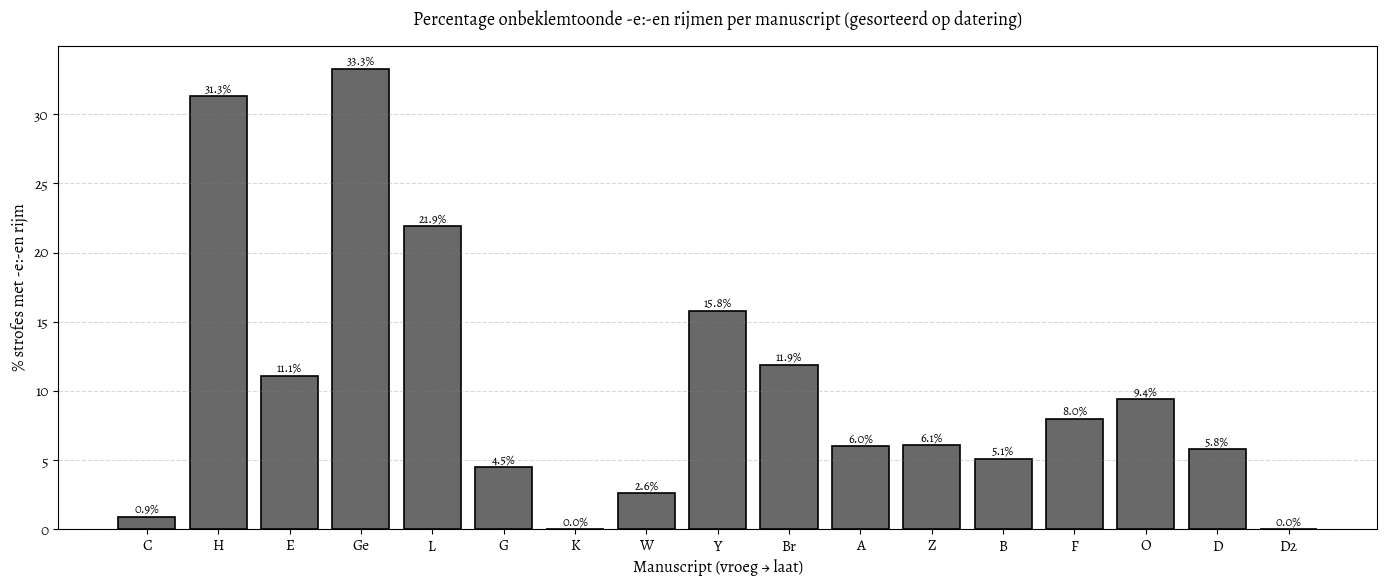

Grafiek 1 opgeslagen: e_en_by_date_inclusiefC.png


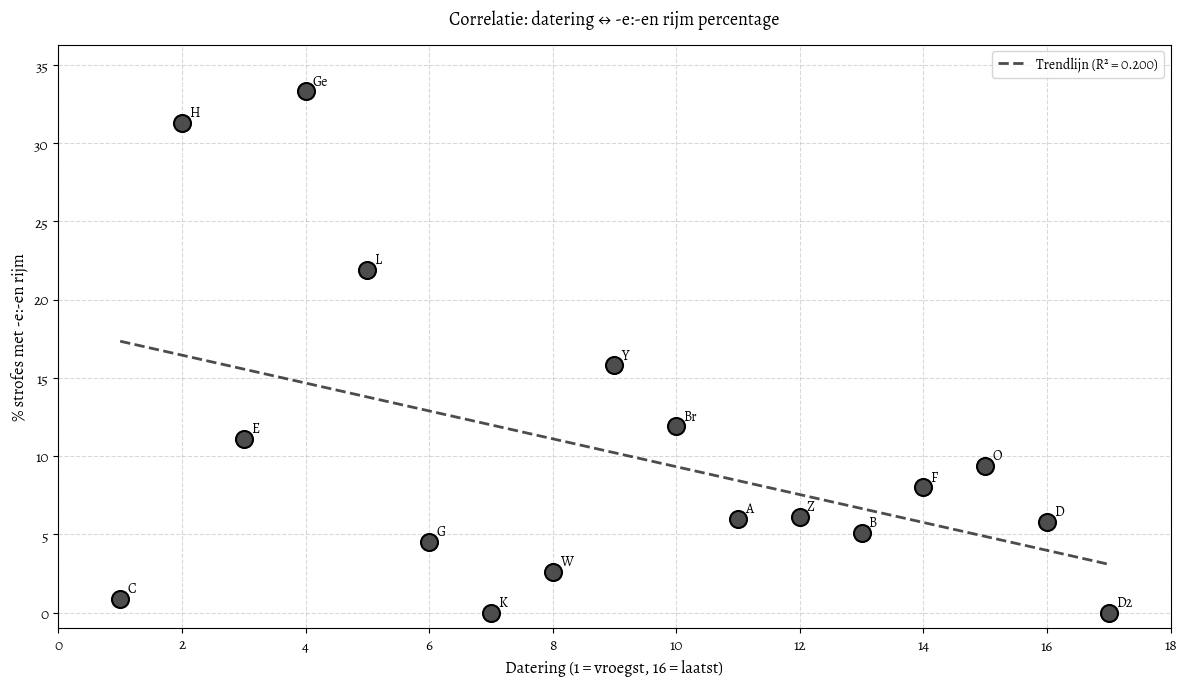

Grafiek 2 opgeslagen: e_en_correlation_date.png

DIRECTIONELE STATISTISCHE ANALYSE

Pearson correlatie:
  r = -0.447
  p-waarde (tweezijdig) = 0.0720

Directionele testen:
  H₁: r < 0 (Van Dalen-Oskam hypothese)
    → p(eenzijdig) = 0.0360
    ✓ Significante NEGATIEVE correlatie
      Latere manuscripten hebben MINDER -e:-en rijmen

  H₁: r > 0 (Verdam & Leendertz hypothese)
    → p(eenzijdig) = 0.9640
    ✗ Geen significante positieve correlatie

Spearman correlatie (robuuster voor outliers):
  ρ = -0.289
  p(eenzijdig, H₁: ρ < 0) = 0.1299
  p(eenzijdig, H₁: ρ > 0) = 0.8701

Vergelijking vroeg vs laat:
  Vroege manuscripten (1-6):  17.17%
  Late manuscripten (12-16):  5.73%
  Verschil:                    -11.43 procentpunten


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, linregress, spearmanr
import scipy.stats as stats
from matplotlib import font_manager

# Font instellen
plt.rcParams['font.family'] = 'Alegreya'
plt.rcParams['font.size'] = 11

# Data
data = {
    'Manuscript': ['H', 'E', 'Ge', 'L', 'G', 'K', 'W', 'Y', 'Br', 'A', 'Z', 'B', 'F', 'O', 'D', 'D2'],
    'Strofes_met_e_of_en': [16, 18, 6, 32, 134, 5, 39, 19, 42, 134, 33, 138, 138, 138, 137, 8],
    'Strofes_met_e_en_rijm': [5, 2, 2, 7, 6, 0, 1, 3, 5, 8, 2, 7, 11, 13, 8, 0],
    'Percentage': [31.3, 11.1, 33.3, 21.9, 4.5, 0, 2.6, 15.8, 11.9, 6.0, 6.1, 5.1, 8.0, 9.4, 5.8, 0.0]
}
data = {
    'Manuscript': ['C', 'H', 'E', 'Ge', 'L', 'G', 'K', 'W', 'Y', 'Br', 'A', 'Z', 'B', 'F', 'O', 'D', 'D2'],
    'Strofes_met_e_of_en': [111, 16, 18, 6, 32, 134, 5, 39, 19, 42, 134, 33, 138, 138, 138, 137, 8],
    'Strofes_met_e_en_rijm': [1, 5, 2, 2, 7, 6, 0, 1, 3, 5, 8, 2, 7, 11, 13, 8, 0],
    'Percentage': [0.9, 31.3, 11.1, 33.3, 21.9, 4.5, 0, 2.6, 15.8, 11.9, 6.0, 6.1, 5.1, 8.0, 9.4, 5.8, 0.0]
}
df = pd.DataFrame(data)
df['Datering_volgorde'] = range(1, len(df) + 1)

# ============================================================================
# GRAFIEK 1: Bar chart (grijstinten)
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(df['Manuscript'], df['Percentage'], 
              color='#696969', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Manuscript (vroeg → laat)', fontsize=12)
ax.set_ylabel('% strofes met -e:-en rijm', fontsize=12)
ax.set_title('Percentage onbeklemtoonde -e:-en rijmen per manuscript (gesorteerd op datering)', 
             fontsize=13, pad=15)
ax.grid(axis='y', alpha=0.3, color='gray', linestyle='--')

for bar, pct in zip(bars, df['Percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, 
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../data/e_en_by_date.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafiek 1 opgeslagen: e_en_by_date_inclusiefC.png")

# ============================================================================
# GRAFIEK 2: Scatter plot met trendlijn (grijstinten)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(df['Datering_volgorde'], df['Percentage'], 
          s=150, color='#4d4d4d', edgecolor='black', linewidth=1.5, zorder=3)

for idx, row in df.iterrows():
    ax.annotate(row['Manuscript'], 
                (row['Datering_volgorde'], row['Percentage']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

slope, intercept, r_value, p_value, std_err = linregress(
    df['Datering_volgorde'], df['Percentage'])
line = slope * df['Datering_volgorde'] + intercept

ax.plot(df['Datering_volgorde'], line, 
        color='black', linestyle='--', linewidth=2, alpha=0.7,
        label=f'Trendlijn (R² = {r_value**2:.3f})')

ax.set_xlabel('Datering (1 = vroegst, 16 = laatst)', fontsize=12)
ax.set_ylabel('% strofes met -e:-en rijm', fontsize=12)
ax.set_title('Correlatie: datering ↔ -e:-en rijm percentage', fontsize=13, pad=15)

ax.grid(True, alpha=0.3, color='gray', linestyle='--')
ax.legend(fontsize=10, loc='best')
ax.set_xlim(0, 18)
ax.set_ylim(-1, max(df['Percentage']) + 3)

plt.tight_layout()
plt.savefig('../data/e_en_correlation_date_inclusiefC.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafiek 2 opgeslagen: e_en_correlation_date.png")

# ============================================================================
# DIRECTIONELE STATISTISCHE ANALYSE
# ============================================================================
print("\n" + "="*70)
print("DIRECTIONELE STATISTISCHE ANALYSE")
print("="*70)

# Pearson correlatie
pearson_r, pearson_p_twotailed = pearsonr(df['Datering_volgorde'], df['Percentage'])

# Bereken eenzijdige p-waarden
n = len(df)
t_statistic = pearson_r * np.sqrt(n - 2) / np.sqrt(1 - pearson_r**2)

# H₁: r < 0 (latere mss = MINDER -e:-en → Van Dalen-Oskam)
p_negative = stats.t.cdf(t_statistic, df=n-2)

# H₁: r > 0 (latere mss = MEER -e:-en → Verdam & Leendertz)
p_positive = 1 - stats.t.cdf(t_statistic, df=n-2)

print(f"\nPearson correlatie:")
print(f"  r = {pearson_r:.3f}")
print(f"  p-waarde (tweezijdig) = {pearson_p_twotailed:.4f}")
print(f"\nDirectionele testen:")
print(f"  H₁: r < 0 (Van Dalen-Oskam hypothese)")
print(f"    → p(eenzijdig) = {p_negative:.4f}")
if p_negative < 0.05:
    print(f"    ✓ Significante NEGATIEVE correlatie")
    print(f"      Latere manuscripten hebben MINDER -e:-en rijmen")
else:
    print(f"    ✗ Geen significante negatieve correlatie")

print(f"\n  H₁: r > 0 (Verdam & Leendertz hypothese)")
print(f"    → p(eenzijdig) = {p_positive:.4f}")
if p_positive < 0.05:
    print(f"    ✓ Significante POSITIEVE correlatie")
    print(f"      Latere manuscripten hebben MEER -e:-en rijmen")
else:
    print(f"    ✗ Geen significante positieve correlatie")

# Spearman (robuuster voor outliers)
spearman_r, spearman_p_twotailed = spearmanr(df['Datering_volgorde'], df['Percentage'])
t_stat_spearman = spearman_r * np.sqrt(n - 2) / np.sqrt(1 - spearman_r**2)
p_negative_spearman = stats.t.cdf(t_stat_spearman, df=n-2)
p_positive_spearman = 1 - stats.t.cdf(t_stat_spearman, df=n-2)

print(f"\nSpearman correlatie (robuuster voor outliers):")
print(f"  ρ = {spearman_r:.3f}")
print(f"  p(eenzijdig, H₁: ρ < 0) = {p_negative_spearman:.4f}")
print(f"  p(eenzijdig, H₁: ρ > 0) = {p_positive_spearman:.4f}")

# Vergelijk vroeg vs laat
vroeg = df[df['Datering_volgorde'] <= 6]['Percentage'].mean()
laat = df[df['Datering_volgorde'] >= 12]['Percentage'].mean()

print(f"\nVergelijking vroeg vs laat:")
print(f"  Vroege manuscripten (1-6):  {vroeg:.2f}%")
print(f"  Late manuscripten (12-16):  {laat:.2f}%")
print(f"  Verschil:                    {laat - vroeg:+.2f} procentpunten")

## Correlatie afstand tot de root en -e:-en:rijmen

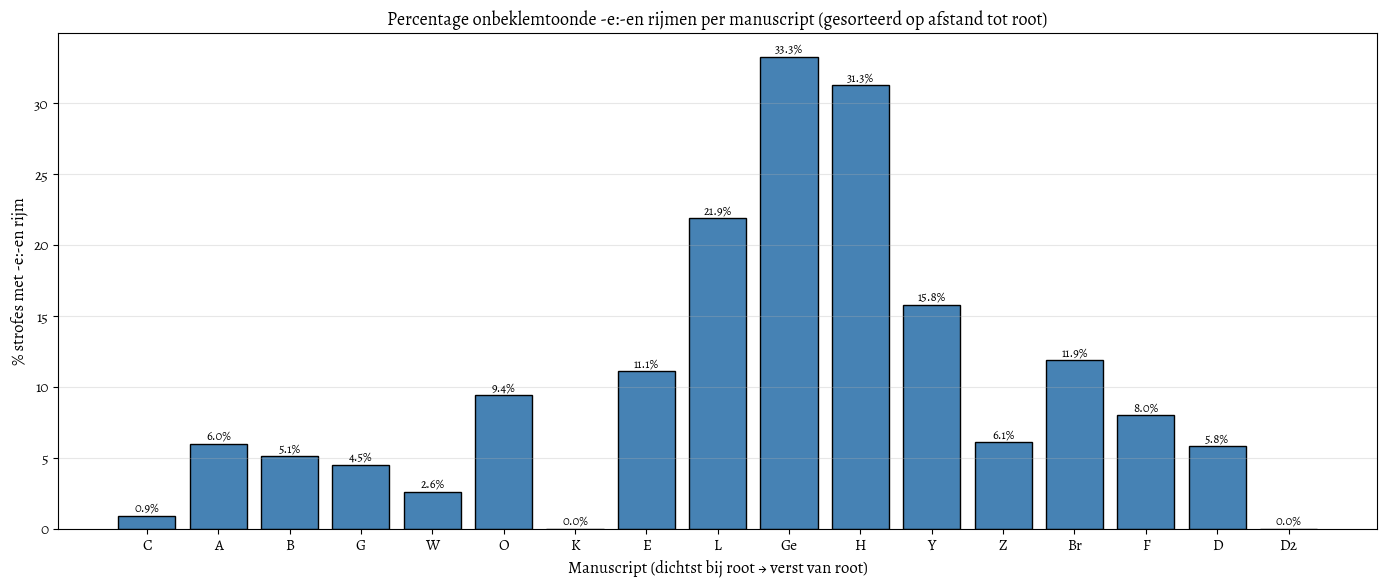

Grafiek 1 opgeslagen: e_en_by_root.png


/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_85111/499018861.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(df['Afstand_volgorde'], line, 'r--', linewidth=2, alpha=0.7, color='black',


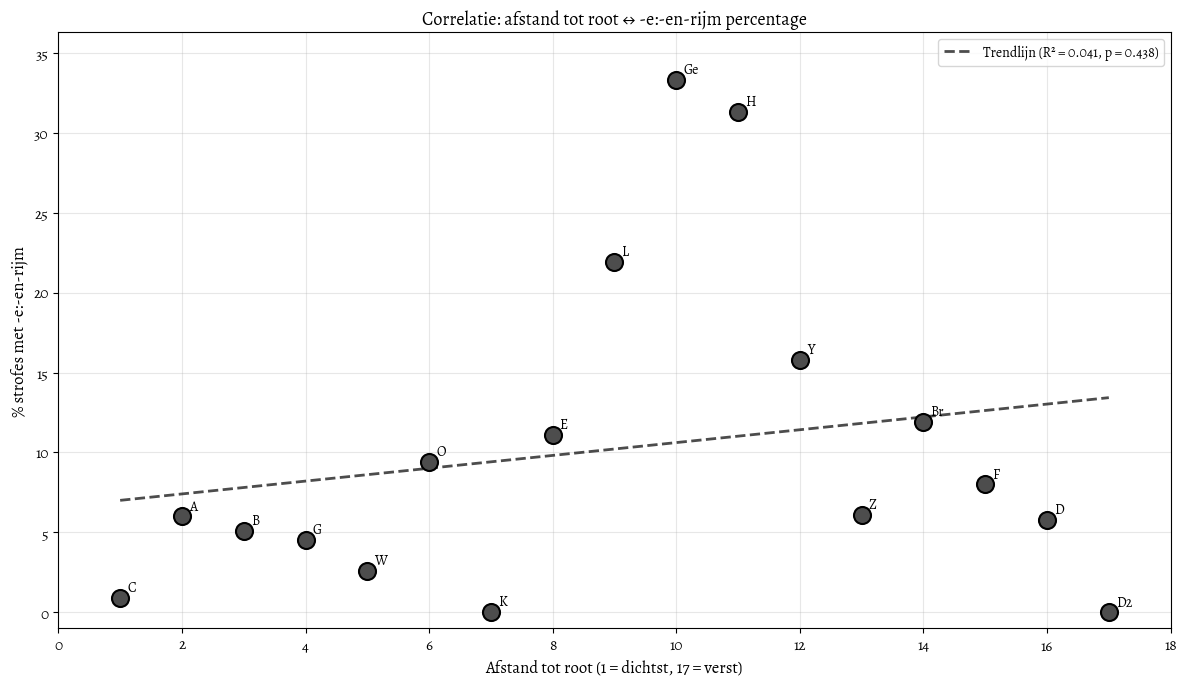

Grafiek 2 opgeslagen: e_en_correlation_root.png

STATISTISCHE ANALYSE

Correlatie afstand tot root vs percentage:
  Pearson r = 0.201
  p-waarde  = 0.4382

✗ GEEN significante correlatie
  → Afstand tot root verklaart niet het -e:-en percentage

Vergelijking dichtbij vs ver van root:
  Dichtbij root (1-5):  3.82%
  Ver van root (13-17): 6.36%
  Verschil:              2.54 procentpunten

→ Verder van root = MEER -e:-en rijm
→ Suggereert: kopiisten introduceerden het



In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, linregress

# Data gesorteerd op afstand tot root (zoals jij hebt gegeven)

data = {
    'Manuscript': ['A', 'B', 'G', 'W', 'O', 'K', 'E', 'L', 'Ge', 'H', 'Y', 'Z', 'Br', 'F', 'D', 'D2'],
    'Strofes_met_e_of_en': [134, 138, 134, 39, 138, 5, 18, 32, 6, 16, 19, 33, 42, 138, 137, 8],
    'Strofes_met_e_en_rijm': [8, 7, 6, 1, 13, 0, 2, 7, 2, 5, 3, 2, 5, 11, 8, 0],
    'Percentage': [6.0, 5.1, 4.5, 2.6, 9.4, 0.0, 11.1, 21.9, 33.3, 31.3, 15.8, 6.1, 11.9, 8.0, 5.8, 0.0]
}
data = {
    'Manuscript': ['C', 'A', 'B', 'G', 'W', 'O', 'K', 'E', 'L', 'Ge', 'H', 'Y', 'Z', 'Br', 'F', 'D', 'D2'],
    'Strofes_met_e_of_en': [111, 134, 138, 134, 39, 138, 5, 18, 32, 6, 16, 19, 33, 42, 138, 137, 8],
    'Strofes_met_e_en_rijm': [1, 8, 7, 6, 1, 13, 0, 2, 7, 2, 5, 3, 2, 5, 11, 8, 0],
    'Percentage': [0.9, 6.0, 5.1, 4.5, 2.6, 9.4, 0.0, 11.1, 21.9, 33.3, 31.3, 15.8, 6.1, 11.9, 8.0, 5.8, 0.0]
}

df = pd.DataFrame(data)
df['Afstand_volgorde'] = range(1, len(df) + 1)

# ============================================================================
# GRAFIEK 1: Simpele bar chart
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(df['Manuscript'], df['Percentage'], 
              color='steelblue', edgecolor='black', linewidth=1)

ax.set_xlabel('Manuscript (dichtst bij root → verst van root)', fontsize=12)
ax.set_ylabel('% strofes met -e:-en rijm', fontsize=12)
ax.set_title('Percentage onbeklemtoonde -e:-en rijmen per manuscript (gesorteerd op afstand tot root)', fontsize=13)
ax.grid(axis='y', alpha=0.3)

# Percentages boven balken
for bar, pct in zip(bars, df['Percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../data/e_en_by_root_inclusiefC.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafiek 1 opgeslagen: e_en_by_root.png")

# ============================================================================
# GRAFIEK 2: Scatter plot met trendlijn
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Scatter
ax.scatter(df['Afstand_volgorde'], df['Percentage'], 
          s=150, color='#4d4d4d', edgecolor='black', linewidth=1.5, zorder=3)

# Labels
for idx, row in df.iterrows():
    ax.annotate(row['Manuscript'], 
                (row['Afstand_volgorde'], row['Percentage']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# Trendlijn
slope, intercept, r_value, p_value, std_err = linregress(df['Afstand_volgorde'], df['Percentage'])
line = slope * df['Afstand_volgorde'] + intercept
ax.plot(df['Afstand_volgorde'], line, 'r--', linewidth=2, alpha=0.7, color='black',
        label=f'Trendlijn (R² = {r_value**2:.3f}, p = {p_value:.3f})')

ax.set_xlabel('Afstand tot root (1 = dichtst, 17 = verst)', fontsize=12)
ax.set_ylabel('% strofes met -e:-en-rijm', fontsize=12)
ax.set_title('Correlatie: afstand tot root ↔ -e:-en-rijm percentage', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_xlim(0, 18)
ax.set_ylim(-1, max(df['Percentage']) + 3)

plt.tight_layout()
plt.savefig('../data/e_en_correlation_root_inclusiefC.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafiek 2 opgeslagen: e_en_correlation_root.png")

# ============================================================================
# STATISTIEKEN
# ============================================================================

print("\n" + "="*60)
print("STATISTISCHE ANALYSE")
print("="*60)

pearson_r, pearson_p = pearsonr(df['Afstand_volgorde'], df['Percentage'])

print(f"\nCorrelatie afstand tot root vs percentage:")
print(f"  Pearson r = {pearson_r:.3f}")
print(f"  p-waarde  = {pearson_p:.4f}")

if pearson_p < 0.05:
    if pearson_r > 0:
        print(f"\n✓ Significante POSITIEVE correlatie")
        print(f"  → Verder van root = MEER -e:-en rijm")
        print(f"  → Ondersteunt VERDAM & LEENDERTZ")
        print(f"    (kopiisten introduceerden -e:-en rijmen)")
    else:
        print(f"\n✓ Significante NEGATIEVE correlatie")
        print(f"  → Verder van root = MINDER -e:-en rijm")
        print(f"  → Ondersteunt VAN DALEN-OSKAM")
        print(f"    (kopiisten egaliseerden -e:-en)")
else:
    print(f"\n✗ GEEN significante correlatie")
    print(f"  → Afstand tot root verklaart niet het -e:-en percentage")

# Vergelijk dichtbij vs ver
dichtbij = df[df['Afstand_volgorde'] <= 5]['Percentage'].mean()
ver = df[df['Afstand_volgorde'] >= 13]['Percentage'].mean()

print(f"\nVergelijking dichtbij vs ver van root:")
print(f"  Dichtbij root (1-5):  {dichtbij:.2f}%")
print(f"  Ver van root (13-17): {ver:.2f}%")
print(f"  Verschil:              {ver - dichtbij:.2f} procentpunten")

if ver > dichtbij:
    print(f"\n→ Verder van root = MEER -e:-en rijm")
    print(f"→ Suggereert: kopiisten introduceerden het")
else:
    print(f"\n→ Dichtbij root = MEER -e:-en rijm")
    print(f"→ Suggereert: kopiisten egaliseerden het")

print("\n" + "="*60)